In [282]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import PIL
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Flatten, Dense, AvgPool2D

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.2.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
def get_command_line_args(_args):
    parser = utils._build_parser()

    parser = parser.parse_args(_args)

    utils.check_args_validity(parser)

    print("=" * 20 + "\nParameters: \n")
    for key in parser.__dict__:
        print(key + ': ' + str(parser.__dict__[key]))
    print("=" * 20 + "\n")
    return parser

def plot_roc(y_true,y_scores, name="Current Model"):
    from sklearn.metrics import roc_curve
    import plotly.graph_objects as go
    fpr,tpr,_thresh = roc_curve(y_true, y_scores)

    data = go.Scatter(
        x = fpr,
        y = tpr,
        mode="lines",
        name=name
    )
    baseline = go.Scatter(
        x = [0,1],
        y = [0,1],
        line={"dash":"dash"},
        name="Random Classifier"
    )

    auc_annotation =  go.layout.Annotation(
        text='AUC: {:.3f}'.format(roc_auc_score(y_true, y_scores)),
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0.9,
        y=0.1,
        bordercolor='black',
        borderwidth=1,
        font_size=16
    )

    fig = go.Figure(data=[data, baseline],
                    layout=dict(width=800,
                                height=600,
                                annotations=[auc_annotation],
                                title= dict(text="ROC Curve",
                                            font=dict(size=18)),
                                xaxis_title='FPR',
                                yaxis_title='TPR',
                               ))
    return fig

In [5]:
def metrics(inlier_score, outlier_score, plot=False, verbose=False):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import classification_report, average_precision_score
    from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
    
    y_true = np.concatenate((np.zeros(len(inlier_score)),
                             np.ones(len(outlier_score))))
    y_scores = np.concatenate((inlier_score, outlier_score))
    
    prec,rec,thresh = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    roc_auc = roc_auc_score(y_true,y_scores)
    pr_auc = auc(rec,prec)
    ap = average_precision_score(y_true,y_scores)
    
    if plot:    
    
        fig, axs = plt.subplots(1,2, figsize=(16,4))

        sns.lineplot(fpr, tpr, ax=axs[0])
        axs[0].set(
            xlabel="FPR", ylabel="TPR", title="ROC"
        )

        sns.lineplot(rec, prec, ax=axs[1])
        axs[1].set(
            xlabel="Recall", ylabel="Precision", title="Precision-Recall"
        )

        plt.show()
        plt.close()
    
    if verbose:
        print("Inlier vs Outlier")
        print("----------------")
        print("ROC-AUC: {:.4f}".format(roc_auc))
        print("PR-AUC: {:.4f}".format(pr_auc))
        print("Avg Prec: {:.4f}".format(ap))
        
    return roc_auc, ap, pr_auc

In [6]:
from scipy.ndimage import uniform_filter, median_filter

#Smooth first to get rid of spurious outliers
def preproc(x, orig=None):
    x = np.abs(uniform_filter(x, size=3))
    
    # Only consider foreground pixels
#     x = x[orig>0]
    return x

# Selecting Quantile for best separation
def getQuantiles(logits,orig, Q=0.95):    
    quants = [np.quantile(preproc(x,o), Q) for x,o in zip(logits, orig)]
    quants = np.array(quants).reshape(-1,1)
    return quants

## Generating Samples

In [7]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=seg_brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                              "--y_cond"
                             ])
configs.config_values = args
NUM_L = configs.config_values.num_L
SIGMA_HIGH = configs.config_values.sigma_high
SIGMA_LOW = configs.config_values.sigma_low
BEST_SIGMA_IDX = configs.config_values.num_L - 1
SIGMA_LEVELS = tf.math.exp(tf.linspace(tf.math.log(SIGMA_HIGH),
                                       tf.math.log(SIGMA_LOW),
                                       NUM_L))
SPLITS = utils.dict_splits[configs.config_values.dataset]
SPLITS

Parameters: 

experiment: train
dataset: seg_brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: True
max_to_keep: 2



(1, 7)

In [8]:
# save_dir, complete_model_name = utils.get_savemodel_dir()
# brain_model_cond, _, step, _,_ = utils.try_load_model(save_dir,
#                                               step_ckpt=configs.config_values.resume_from,
#                                               verbose=True)

In [9]:
args = get_command_line_args(["--model=refinenet",
                              "--checkpoint_dir=saved_models/",
                              "--filters=64",
                              "--dataset=brain",
                              "--sigma_low=0.01",
                              "--sigma_high=1",
                             ])
configs.config_values = args
save_dir, complete_model_name = utils.get_savemodel_dir()
brain_model, _, step, _,_ = utils.try_load_model(save_dir,
                                              step_ckpt=configs.config_values.resume_from,
                                              verbose=True)

Parameters: 

experiment: train
dataset: brain
model: refinenet
filters: 64
num_L: 10
sigma_low: 0.01
sigma_high: 1.0
sigma_sequence: geometric
steps: 200000
learning_rate: 0.001
batch_size: 128
samples_dir: ./samples/
checkpoint_dir: saved_models/
checkpoint_freq: 5000
resume: True
resume_from: -1
init_samples: 
k: 10
eval_setting: sample
ocnn: False
y_cond: False
max_to_keep: 2

(1, 91, 109, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 91, 109, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 91, 109, 64)  640         images[0][0]                     
__________________________________________________________________________________________

In [22]:
SIGMAS = utils.get_sigma_levels().numpy()

In [10]:
SPLITS

(1, 7)

In [11]:
def load_outlier_data(age="1year"):
    
    DATA_DIR = "/home/Developer/anodetect/data/test/"
    test_paths = glob.glob(DATA_DIR+"/"+age+"/*")
    
    # Create a dictionary describing the features.
    image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'segmentation': tf.io.FixedLenFeature([], tf.string),
    }

    @tf.function
    def _parse_record(example_proto):
        # Parse the input tf.Example proto using the dictionary above.
        return tf.io.parse_single_example(example_proto, image_feature_description)

    @tf.function
    def _parse_mri(example_proto):
        
        # Get the record and put it into a feature dict
        image_features = _parse_record(example_proto)
        
        # Deserialize the mri array 
        mri = tf.io.parse_tensor(image_features['image'],
                                out_type=tf.float32)
        mask = tf.io.parse_tensor(image_features['mask'],
                                out_type=tf.float32)
        seg = tf.io.parse_tensor(image_features['segmentation'],
                                out_type=tf.float32) 
#         x = tf.concat((mri,mask,seg), axis=-1)
        x = tf.concat((mri,seg), axis=-1)
        
        return x

    test  = tf.data.TFRecordDataset(test_paths).map(_parse_mri)

    return test, len(test_paths)

In [12]:
# import tensorflow.keras as keras

# def build(model):
#     x = [layers.Input(name="images", shape=model.in_shape[0][1:]),
#                  layers.Input(name="idx_sigmas", shape=(), dtype=tf.int32)]
#     return keras.Model(inputs=x, outputs=model.call(x))

# m= build(brain_model)
# m.summary()

In [13]:
brain_model

> ### Note that since we do not have masks, background values are not exactly zero
> ### Use an eps instead (default: 1e-10)

In [14]:
@tf.function
def perturb(x):
    x_batch, y_cond = tf.split(x, SPLITS, axis=-1)
    perturbation =  tf.random.normal(shape=x_batch.shape, mean=0, stddev=SIGMA_VALUE)
    x_perturbed = x_batch + perturbation
    x = tf.concat((x_perturbed, y_cond), axis=-1)
    return x

@tf.function
def score_batch(x_batch):
#     x_batch = perturb(x_batch)
    score = brain_model([x_batch, idx_sigmas])
    return score

In [15]:
@tf.function
def remove_segs(x):
    x, segs = tf.split(x, SPLITS, axis=-1)
    return x

In [16]:
# Test Samples in ABCD
min_size = 900
x_outliers = []
ages = ["4year", "6year"]
for age in ages[0:]:
    x_outlier, test_size = load_outlier_data(age)
    x_outliers.append(x_outlier)
    if min_size > test_size:
        min_size = test_size

print("Choosing Sample Size:", min_size)

Choosing Sample Size: 519


In [28]:
BATCH_COUNT = 10
TEST_BATCH=min_size//BATCH_COUNT
print("Testing {} batches of {}: {} samples".format(BATCH_COUNT, TEST_BATCH, TEST_BATCH*BATCH_COUNT))

Testing 10 batches of 51: 510 samples


In [29]:
outlier_datasets = []
for x_outlier in x_outliers:
    x_outlier = x_outlier.shuffle(1000)
    x_outlier = x_outlier.map(remove_segs)
    x_outlier = x_outlier.batch(TEST_BATCH).take(BATCH_COUNT).cache()
#     outlier_batch = next(iter(x_outlier))
    outlier_datasets.append(x_outlier)

In [30]:
x_test =  get_train_test_data("seg_brain")[1]
x_test = x_test.shuffle(1000)
x_test = x_test.map(remove_segs)
x_test = x_test.batch(TEST_BATCH).take(BATCH_COUNT).cache()
inlier_batch = next(iter(x_test))
inlier_batch.shape

TensorShape([51, 91, 109, 1])

## Mixing Scores

In [31]:
logits_shape = (TEST_BATCH*BATCH_COUNT, *inlier_batch.shape[1:-1], 1)
logits_shape

(510, 91, 109, 1)

In [32]:
def compute_scores(x_test):
    
    # Sigma Idx -> Score
    score_dict = []
    
    sigmas = utils.get_sigma_levels().numpy()
    final_logits = tf.zeros(logits_shape)
    progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
    for idx, sigma in enumerate(progress_bar):
        
        progress_bar.set_description("Sigma: {:.4f}".format(sigma))
        _logits =[]
        idx_sigmas = tf.ones(TEST_BATCH,dtype=tf.int32) * idx

        for x_batch in x_test:
            score = brain_model([x_batch, idx_sigmas])
#             x_batch, y_cond = tf.split(x_batch, SPLITS, axis=-1)
#             score = tf.where(x_batch > 1e-10, score,  0)
            _logits.append(score)

        _logits = tf.concat(_logits, axis=0)
        score_dict.append(tf.identity(_logits))
        
#         final_logits += _logits * sigma
    
    return score_dict

In [33]:
%%time
inlier_dist = compute_scores(x_test)

Sigma: 0.0100: 100%|██████████| 10/10 [00:43<00:00,  4.30s/it]

CPU times: user 22.2 s, sys: 4.15 s, total: 26.4 s
Wall time: 43 s


In [34]:
%%time
outlier_dist = compute_scores(outlier_datasets[0])

Sigma: 0.0100: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]

CPU times: user 21.7 s, sys: 3.67 s, total: 25.4 s
Wall time: 43.5 s


In [35]:
%%time
outlier_dist_2 = compute_scores(outlier_datasets[1])

Sigma: 0.0100: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]

CPU times: user 22 s, sys: 3.25 s, total: 25.3 s
Wall time: 43.4 s


In [37]:
# L2-norm same as Frobenius

inlier_agg = tf.add_n([inlier_dist[x] * s for x, s in enumerate(SIGMAS)])
outlier_agg = tf.add_n([outlier_dist[x] * s for x,s in enumerate(SIGMAS)])
outlier_agg_2 = tf.add_n([outlier_dist_2[x] * s for x,s in enumerate(SIGMAS)])

inlier_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
outlier_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()
outlier_score_2 = tf.norm(outlier_agg_2, axis=[1,2], ord="euclidean").numpy()

# inlier_score = tf.norm(inlier_logits, axis=[1,2], ord="euclidean").numpy()
# outlier_score = tf.norm(outlier_logits, axis=[1,2], ord="euclidean").numpy()


df = pd.DataFrame(np.concatenate((inlier_score, 
                                  outlier_score,
                                  outlier_score_2), axis=-1),
             columns=["Inlier", "1 year", "2 year"])
df.describe()

Inlier      1 year      2 year
count  510.000000  510.000000  510.000000
mean   354.120056  365.063354  359.047119
std     12.935790   24.541088   24.111837
min    321.202698  308.700409  312.107635
25%    345.244865  345.667442  340.276718
50%    353.097366  359.977646  354.372101
75%    362.291756  382.750252  375.851379
max    404.612152  442.999359  434.966064

In [40]:
ages

['4year', '6year']

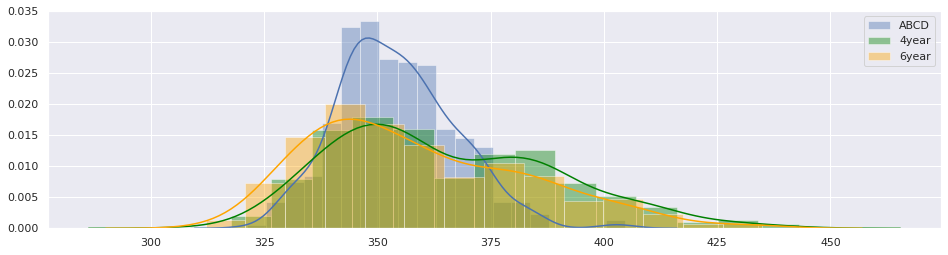

In [42]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
labels = ["ABCD"]+ages
sns.distplot(inlier_score, label=labels[0], ax=ax)
sns.distplot(outlier_score, color="green", label=labels[1], ax=ax)
sns.distplot(outlier_score_2, color="orange", label=labels[2], ax=ax)
plt.legend()
plt.show()

**ABCD vs 4-year**

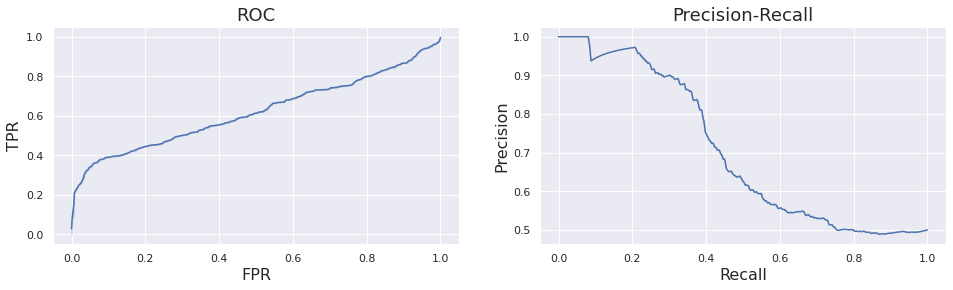

Inlier vs Outlier
----------------
ROC-AUC: 0.6197
PR-AUC: 0.7044
Avg Prec: 0.7047


In [43]:
metrics(inlier_score, outlier_score, plot=True, verbose=True)
plt.show()

**ABCD vs 6-year**

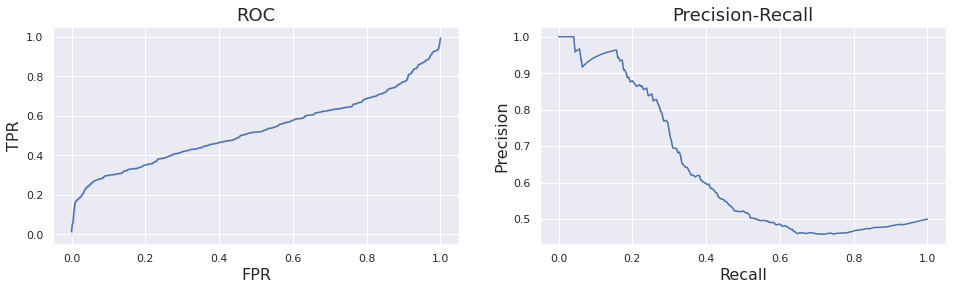

Inlier vs Outlier
----------------
ROC-AUC: 0.5265
PR-AUC: 0.6324
Avg Prec: 0.6328


In [44]:
metrics(inlier_score, outlier_score_2, plot=True, verbose=True)
plt.show()

### Visualizing Scores

In [140]:
# num_samples=3
# inlier_scores = np.square(np.squeeze(inlier_agg.numpy()[0:num_samples]))
# fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples*5))
# for idx, x_score in enumerate(inlier_scores):
#     sns.heatmap(x_score, ax=axs[idx][0])
#     sns.distplot(x_score, ax=axs[idx][1])
# plt.show()

In [141]:
# outlier_scores = np.square(np.squeeze(outlier_agg.numpy()[0:num_samples]))
# fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples*5))
# for idx, x_score in enumerate(outlier_scores):
# #     sns.heatmap(uniform_filter(x_score, size=2), ax=axs[idx][0])
#     sns.heatmap(x_score, ax=axs[idx][0], vmin=0)
#     sns.distplot(x_score[x_score > 1e-10], ax=axs[idx][1])
# plt.show()

Setting V-Max to 33.31519912719727


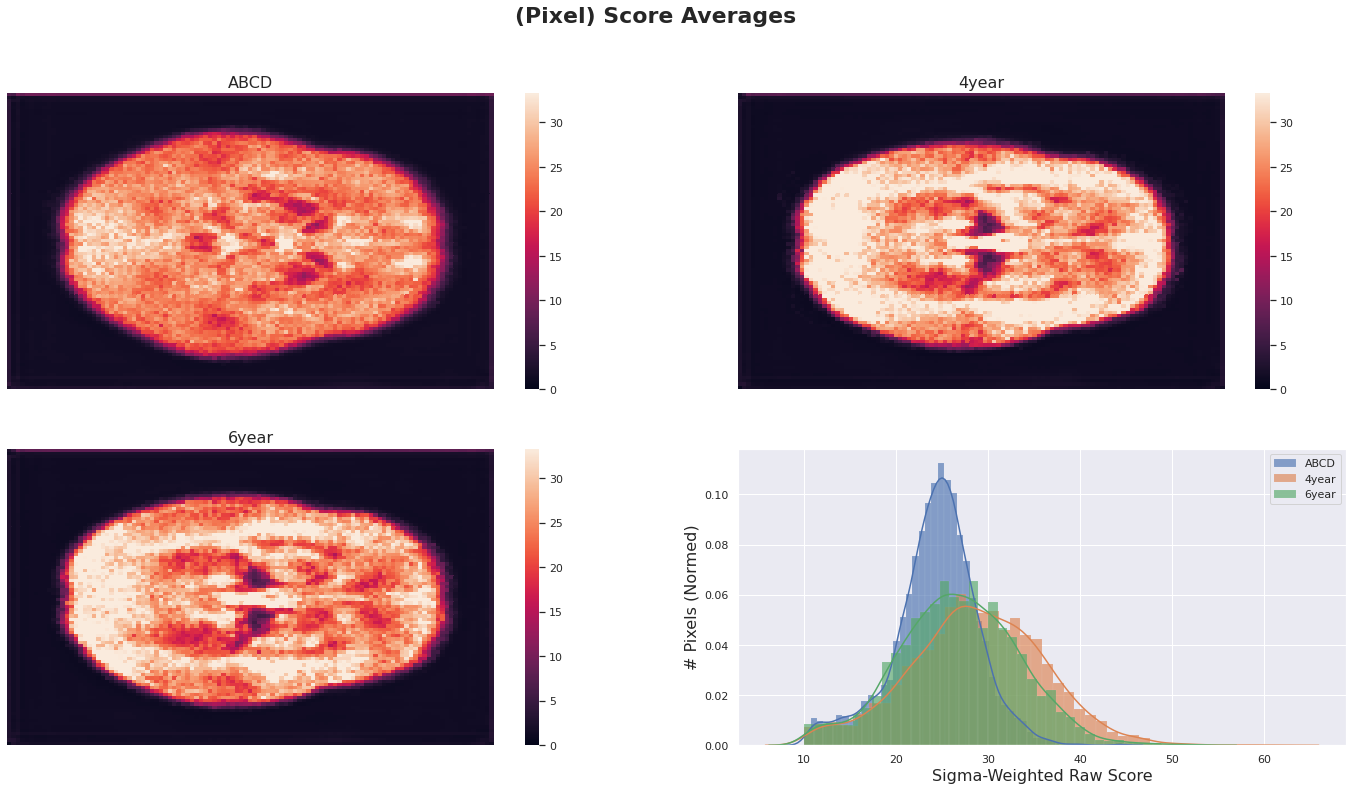

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(24, 12))
# _labels = ["ABCD", "1-year", "2-year"]
axs = axs.flatten()
inler_quantile = None

for i, pixel_scores in enumerate([inlier_agg, outlier_agg, outlier_agg_2]):
    score_avg = np.mean(np.square(np.squeeze(pixel_scores)), axis=0)
    
    if i==0:
        inlier_quantile = np.quantile(score_avg, 0.99)
        print("Setting V-Max to", inlier_quantile)
        
    sns.heatmap(score_avg, ax=axs[i], vmin=0.0, vmax=inlier_quantile)

    # Get rid of x/y ticks
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_ticklabels([])

    _ax = sns.distplot(score_avg[score_avg>10], hist_kws={"alpha":0.65, "linewidth": 0.1}, ax=axs[-1])

_ax.set(xlabel="Sigma-Weighted Raw Score", ylabel="# Pixels (Normed)")    
_ax.legend(labels)

for i,lab in enumerate(labels):
    axs[i].set_title(lab, fontsize=16)

plt.suptitle("(Pixel) Score Averages", fontweight="bold", fontsize=22)
plt.show()

### Mixing without sigma weighting

In [56]:
labels

['ABCD', '4year', '6year']

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s]


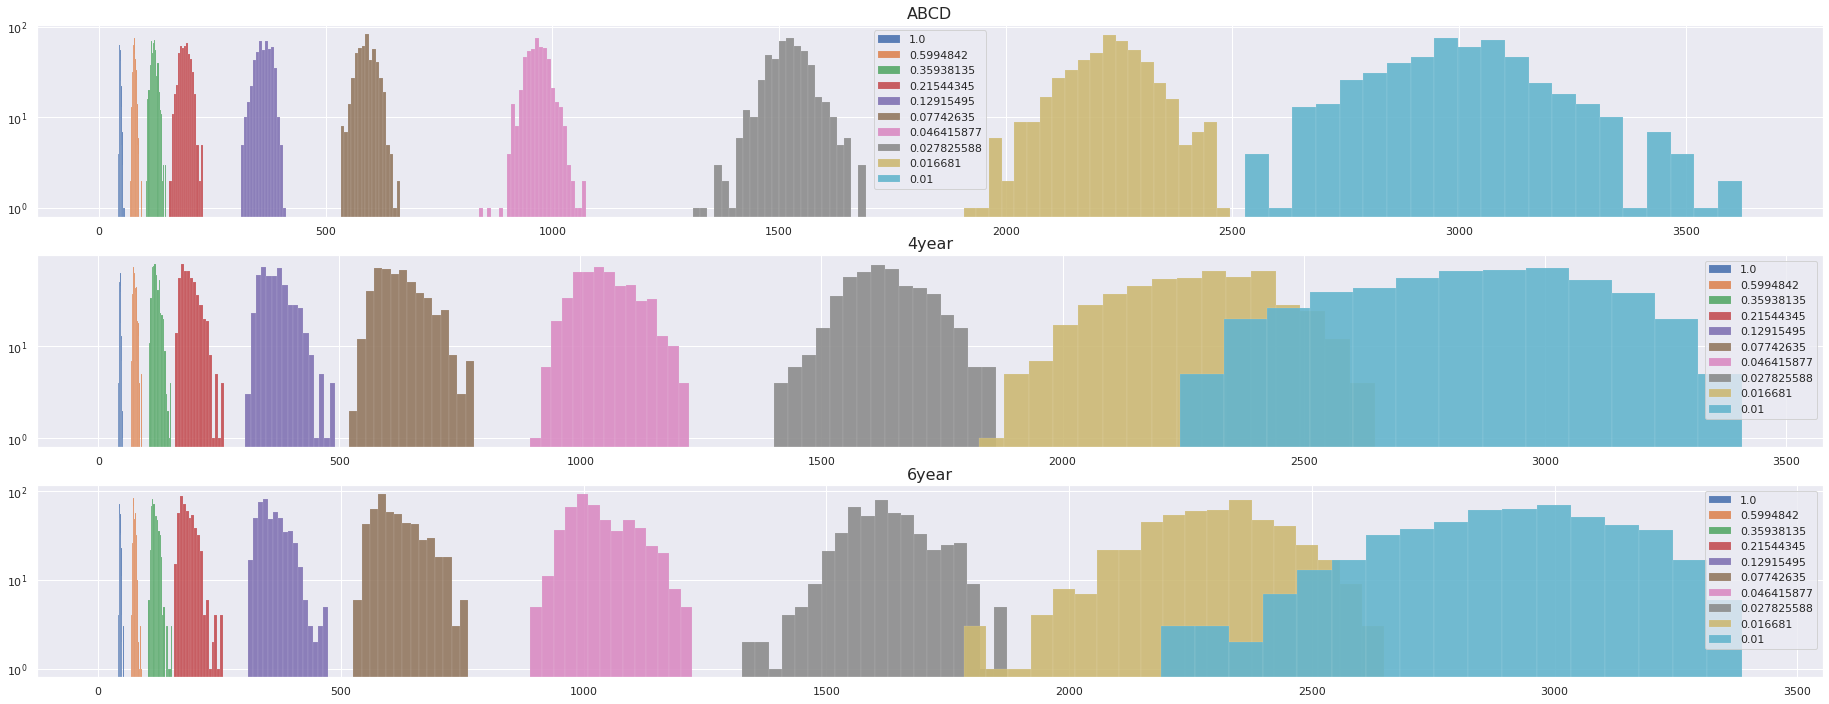

In [59]:
progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(32,12))

for idx, sigma in enumerate(progress_bar):
    for i, x_dist in enumerate([inlier_dist, outlier_dist, outlier_dist_2]):
        _logits = x_dist[idx]
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":True}, kde=False)
        axs[i].set_title(labels[i], fontsize=16)
        axs[i].legend()

plt.show()

### Sigma Weighted Scores 

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


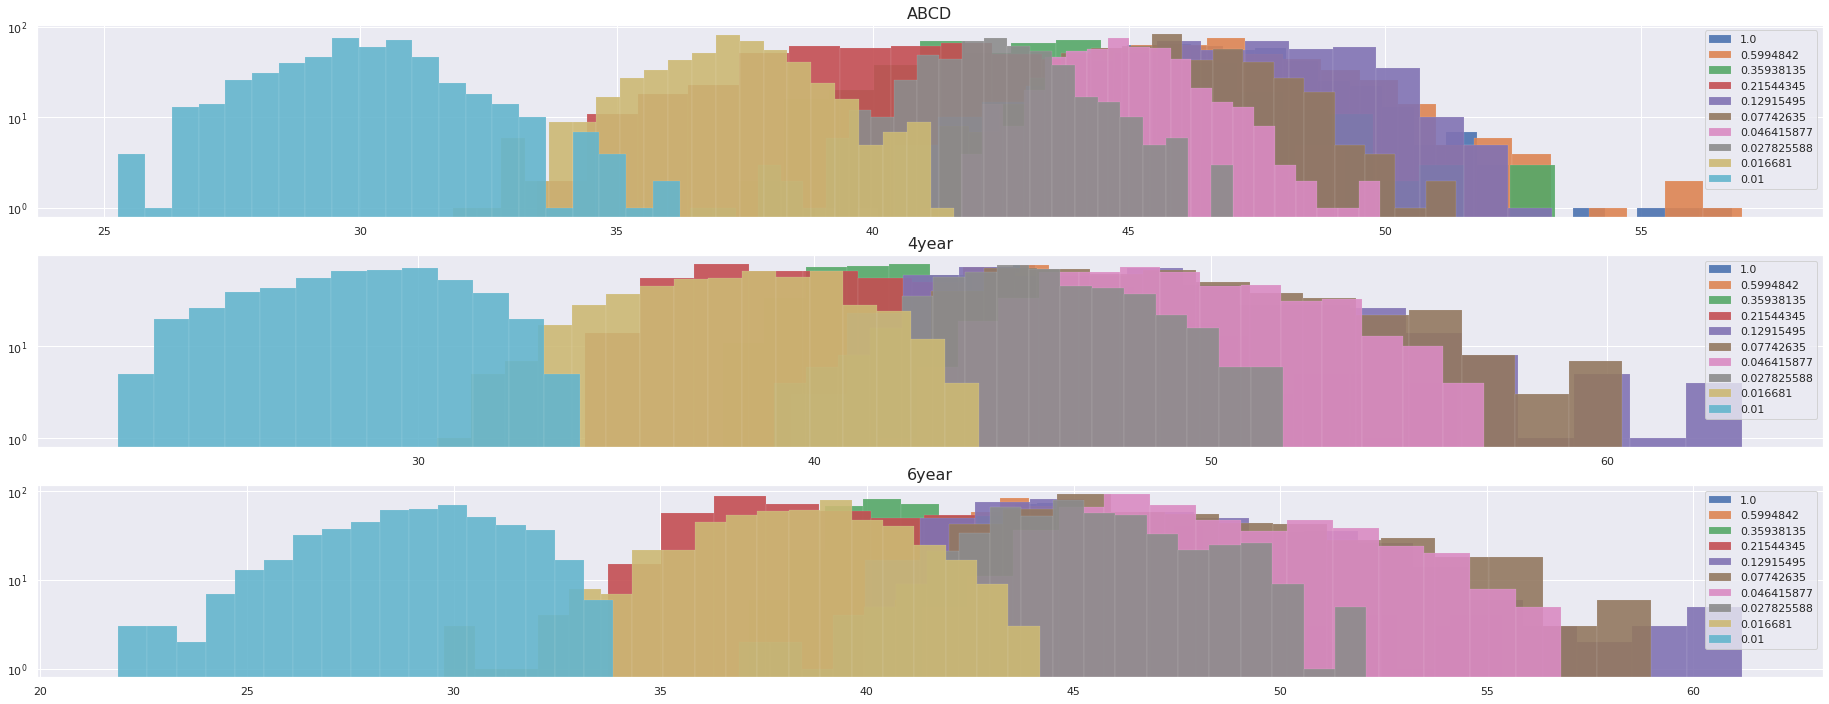

In [60]:
progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
fig, axs = plt.subplots(3,1, figsize=(32,12))

for idx, sigma in enumerate(progress_bar):
    for i, x_dist in enumerate([inlier_dist, outlier_dist, outlier_dist_2]):
        _logits = x_dist[idx] * sigma
        _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
        sns.distplot(_score, label=sigma, ax=axs[i], hist_kws={"alpha":0.9, "linewidth": 0.1, "log":True}, kde=False)
        axs[i].set_title(labels[i], fontsize=16)
        axs[i].legend()

plt.show()

In [64]:
df_arr = []

for (x_dist, name) in zip([inlier_dist, outlier_dist, outlier_dist_2],
                          labels):
    print(name)
    dist_tf = tf.squeeze(tf.stack(x_dist)) * SIGMAS.reshape(-1,1,1,1)
    norms = tf.norm(dist_tf, axis=[2,3], ord="euclidean").numpy()
    _df = pd.DataFrame(norms.T, columns=["{:.2f}".format(x) for x in SIGMAS])
    _df["ID"] = _df.index
    _df["Type"] = name
    
    df_arr.append(_df.copy())

df = pd.concat(df_arr)

melted=df.melt(id_vars=["ID", "Type"], var_name="sigma", value_name="score")

# melted

ABCD
4year
6year


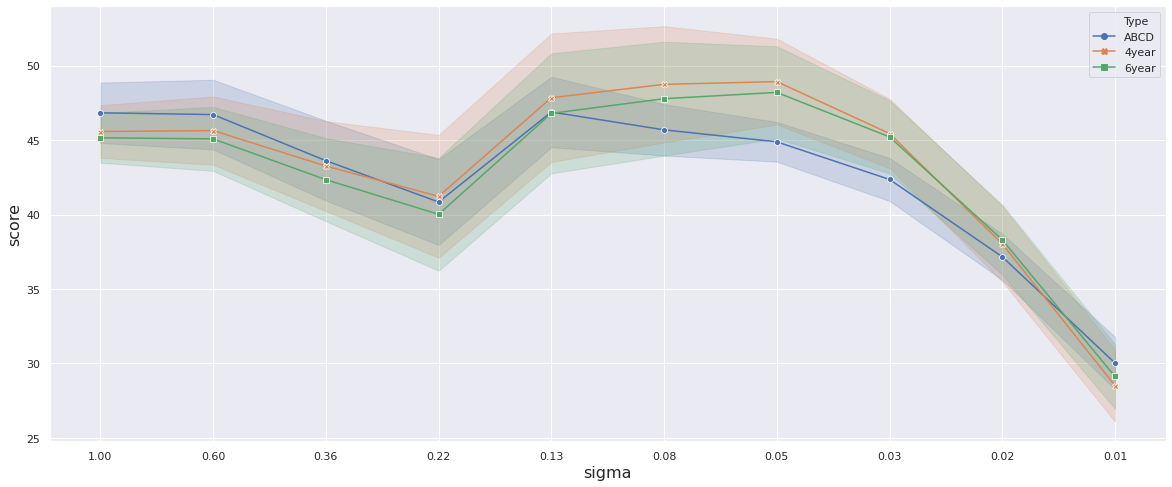

CPU times: user 578 ms, sys: 4.74 ms, total: 583 ms
Wall time: 578 ms


In [65]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci="sd", ax=ax, style="Type", markers=True, dashes=False)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

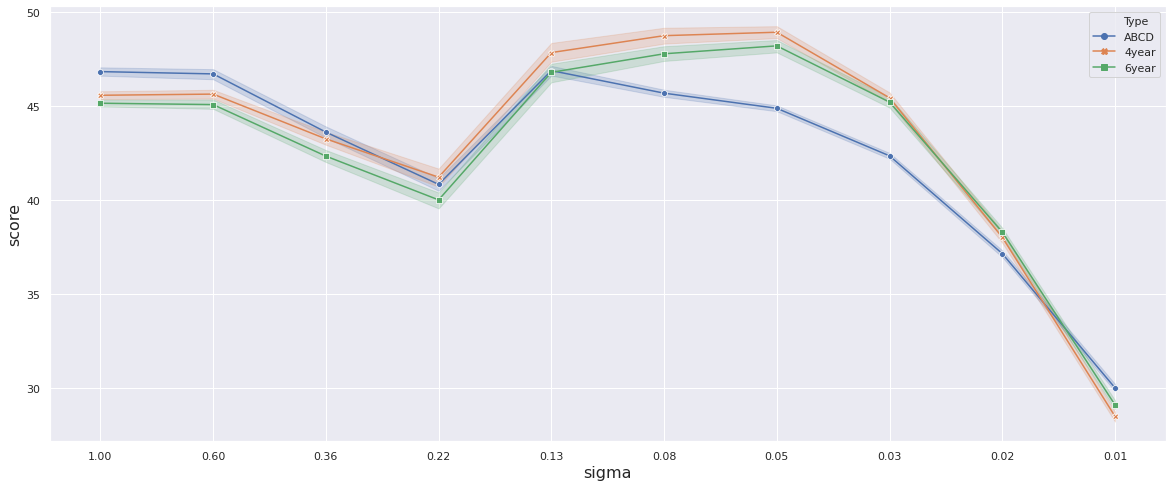

CPU times: user 1.78 s, sys: 7.13 ms, total: 1.78 s
Wall time: 1.78 s


In [66]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, err_style="band", ci=99, ax=ax, style="Type", markers=True, dashes=False)
ax.invert_xaxis()
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

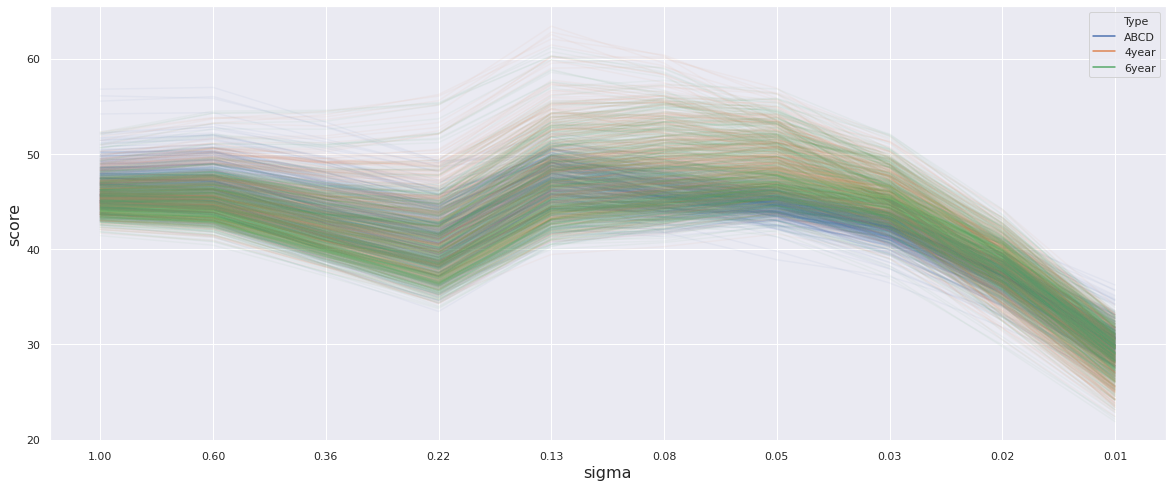

CPU times: user 3.62 s, sys: 13.1 ms, total: 3.64 s
Wall time: 3.63 s


In [67]:
%%time
fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.lineplot(x="sigma", y="score", hue="Type", data=melted, units="ID", estimator=None, alpha=0.05, ax=ax)
ax.invert_xaxis()
plt.show()

### Per Sigma Distribution
<!-- > ### TODO: AUC/PR/AVG in titles ,text box etc. -->

Sigma: ?: 100%|██████████| 10/10 [00:00<00:00, 11.26it/s]


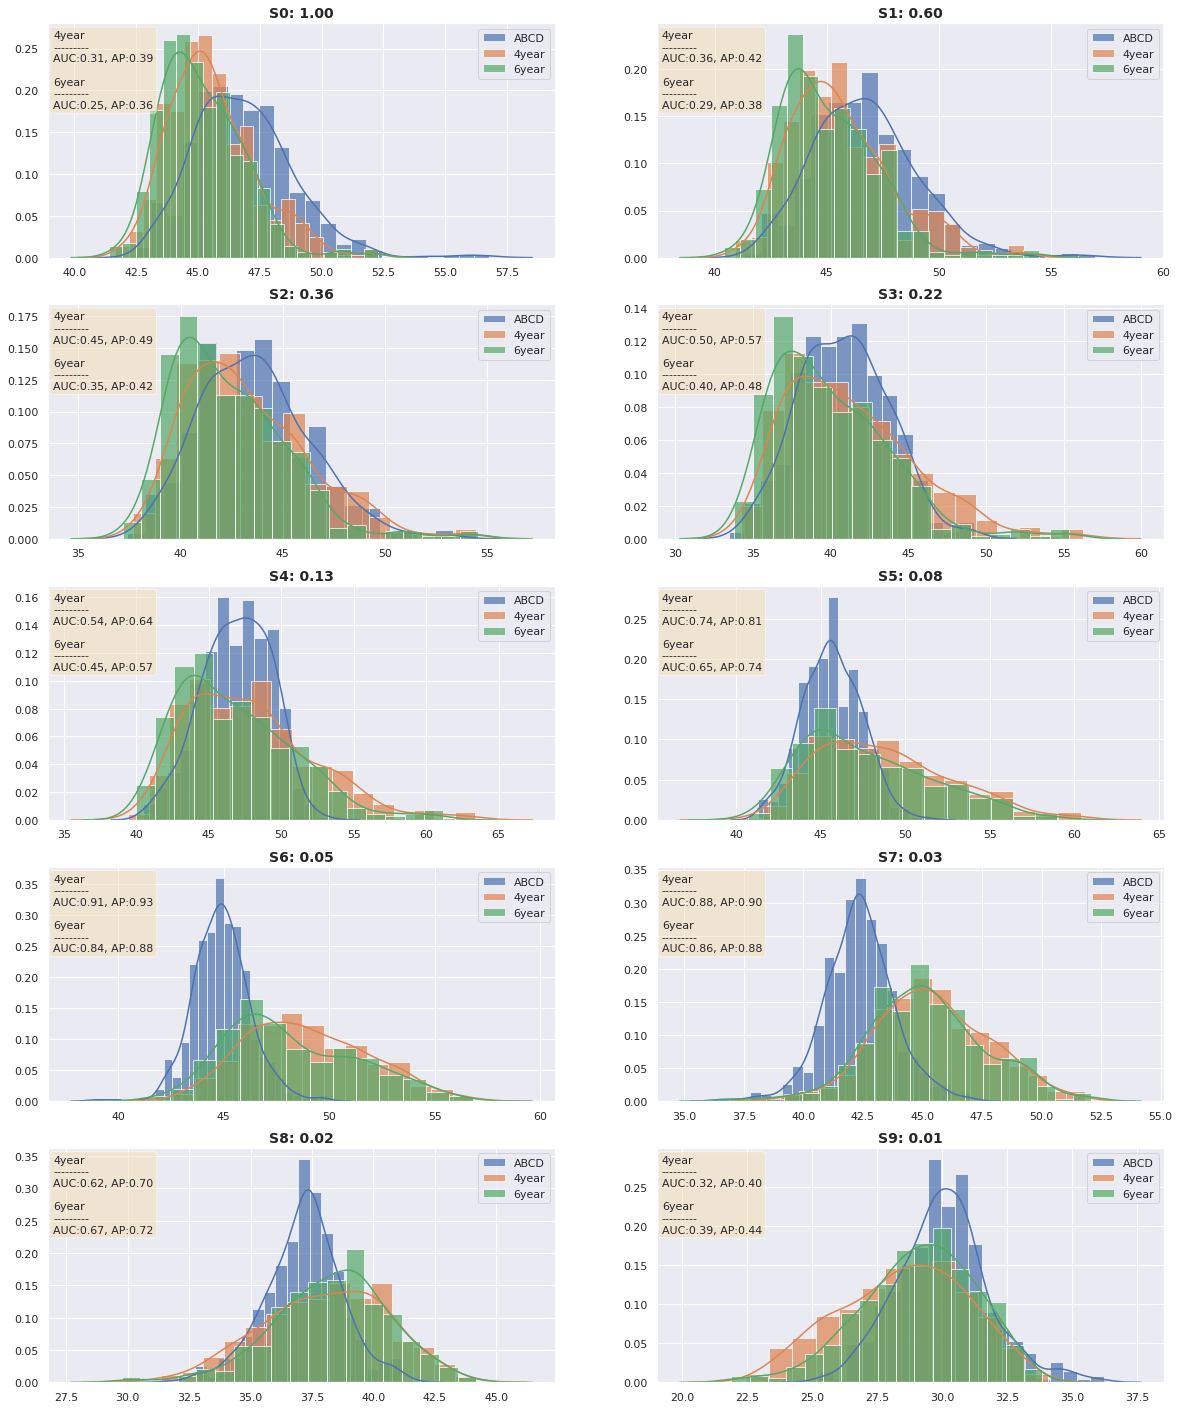

In [69]:
progress_bar = tqdm(SIGMAS, desc='Sigma: ?')
fig, axs = plt.subplots(5,2, figsize=(20,25))
axs = axs.flatten()
for idx, sigma in enumerate(progress_bar):
    progress_bar.set_description("Sigma: {:.4f}".format(sigma))
    
    inlier_logits = inlier_dist[idx] * sigma
    inlier_score =  tf.norm(inlier_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(inlier_score, label=labels[0], ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    outlier_logits = outlier_dist[idx] * sigma
    yr1_score =  tf.norm(outlier_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(yr1_score, label=labels[1], ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)  
    
    outlier_logits = outlier_dist_2[idx] * sigma
    yr2_score =  tf.norm(outlier_logits, axis=[1,2], ord="euclidean").numpy()
    sns.distplot(yr2_score, label=labels[2], ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
    
    textstr = '\n'.join((
        labels[1],
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(inlier_score, yr1_score)[:-1]),
        '',
        labels[2],
        "---------",
        'AUC:%.2f, AP:%.2f' % (metrics(inlier_score, yr2_score)[:-1])))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axs[idx].text(0.01, 0.97, textstr, transform=axs[idx].transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")  
    
    axs[idx].legend()

plt.show()


# progress_bar = tqdm(sigmas, desc='Sigma: ?')
# fig, axs = plt.subplots(5,2, figsize=(16,20))
# axs = axs.flatten()

# for idx, sigma in enumerate(progress_bar):
#     for (score_dist, name) in zip([inlier_dict, outlier_dict, outlier_dict_2],
#                         ["ABCD", "1-year", "2-year"]):
#         _logits = score_dist[idx] * sigma
#         _score =  tf.norm(_logits, axis=[1,2], ord="euclidean").numpy()
#         sns.distplot(_score, label=name, ax=axs[idx], hist_kws={"alpha":0.7}, kde=True)
#         axs[idx].set_title("S{:d}: {:.2f}".format(idx, sigma), fontsize=14, fontweight="bold")
    
# axs[0].legend()
# plt.show()

## Visualizing Scores

> ### Taking ~absolute~ SQUARES of scores then averaging them for every sigma

In [571]:
plt.close()

Sigma: 0.0100: 100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


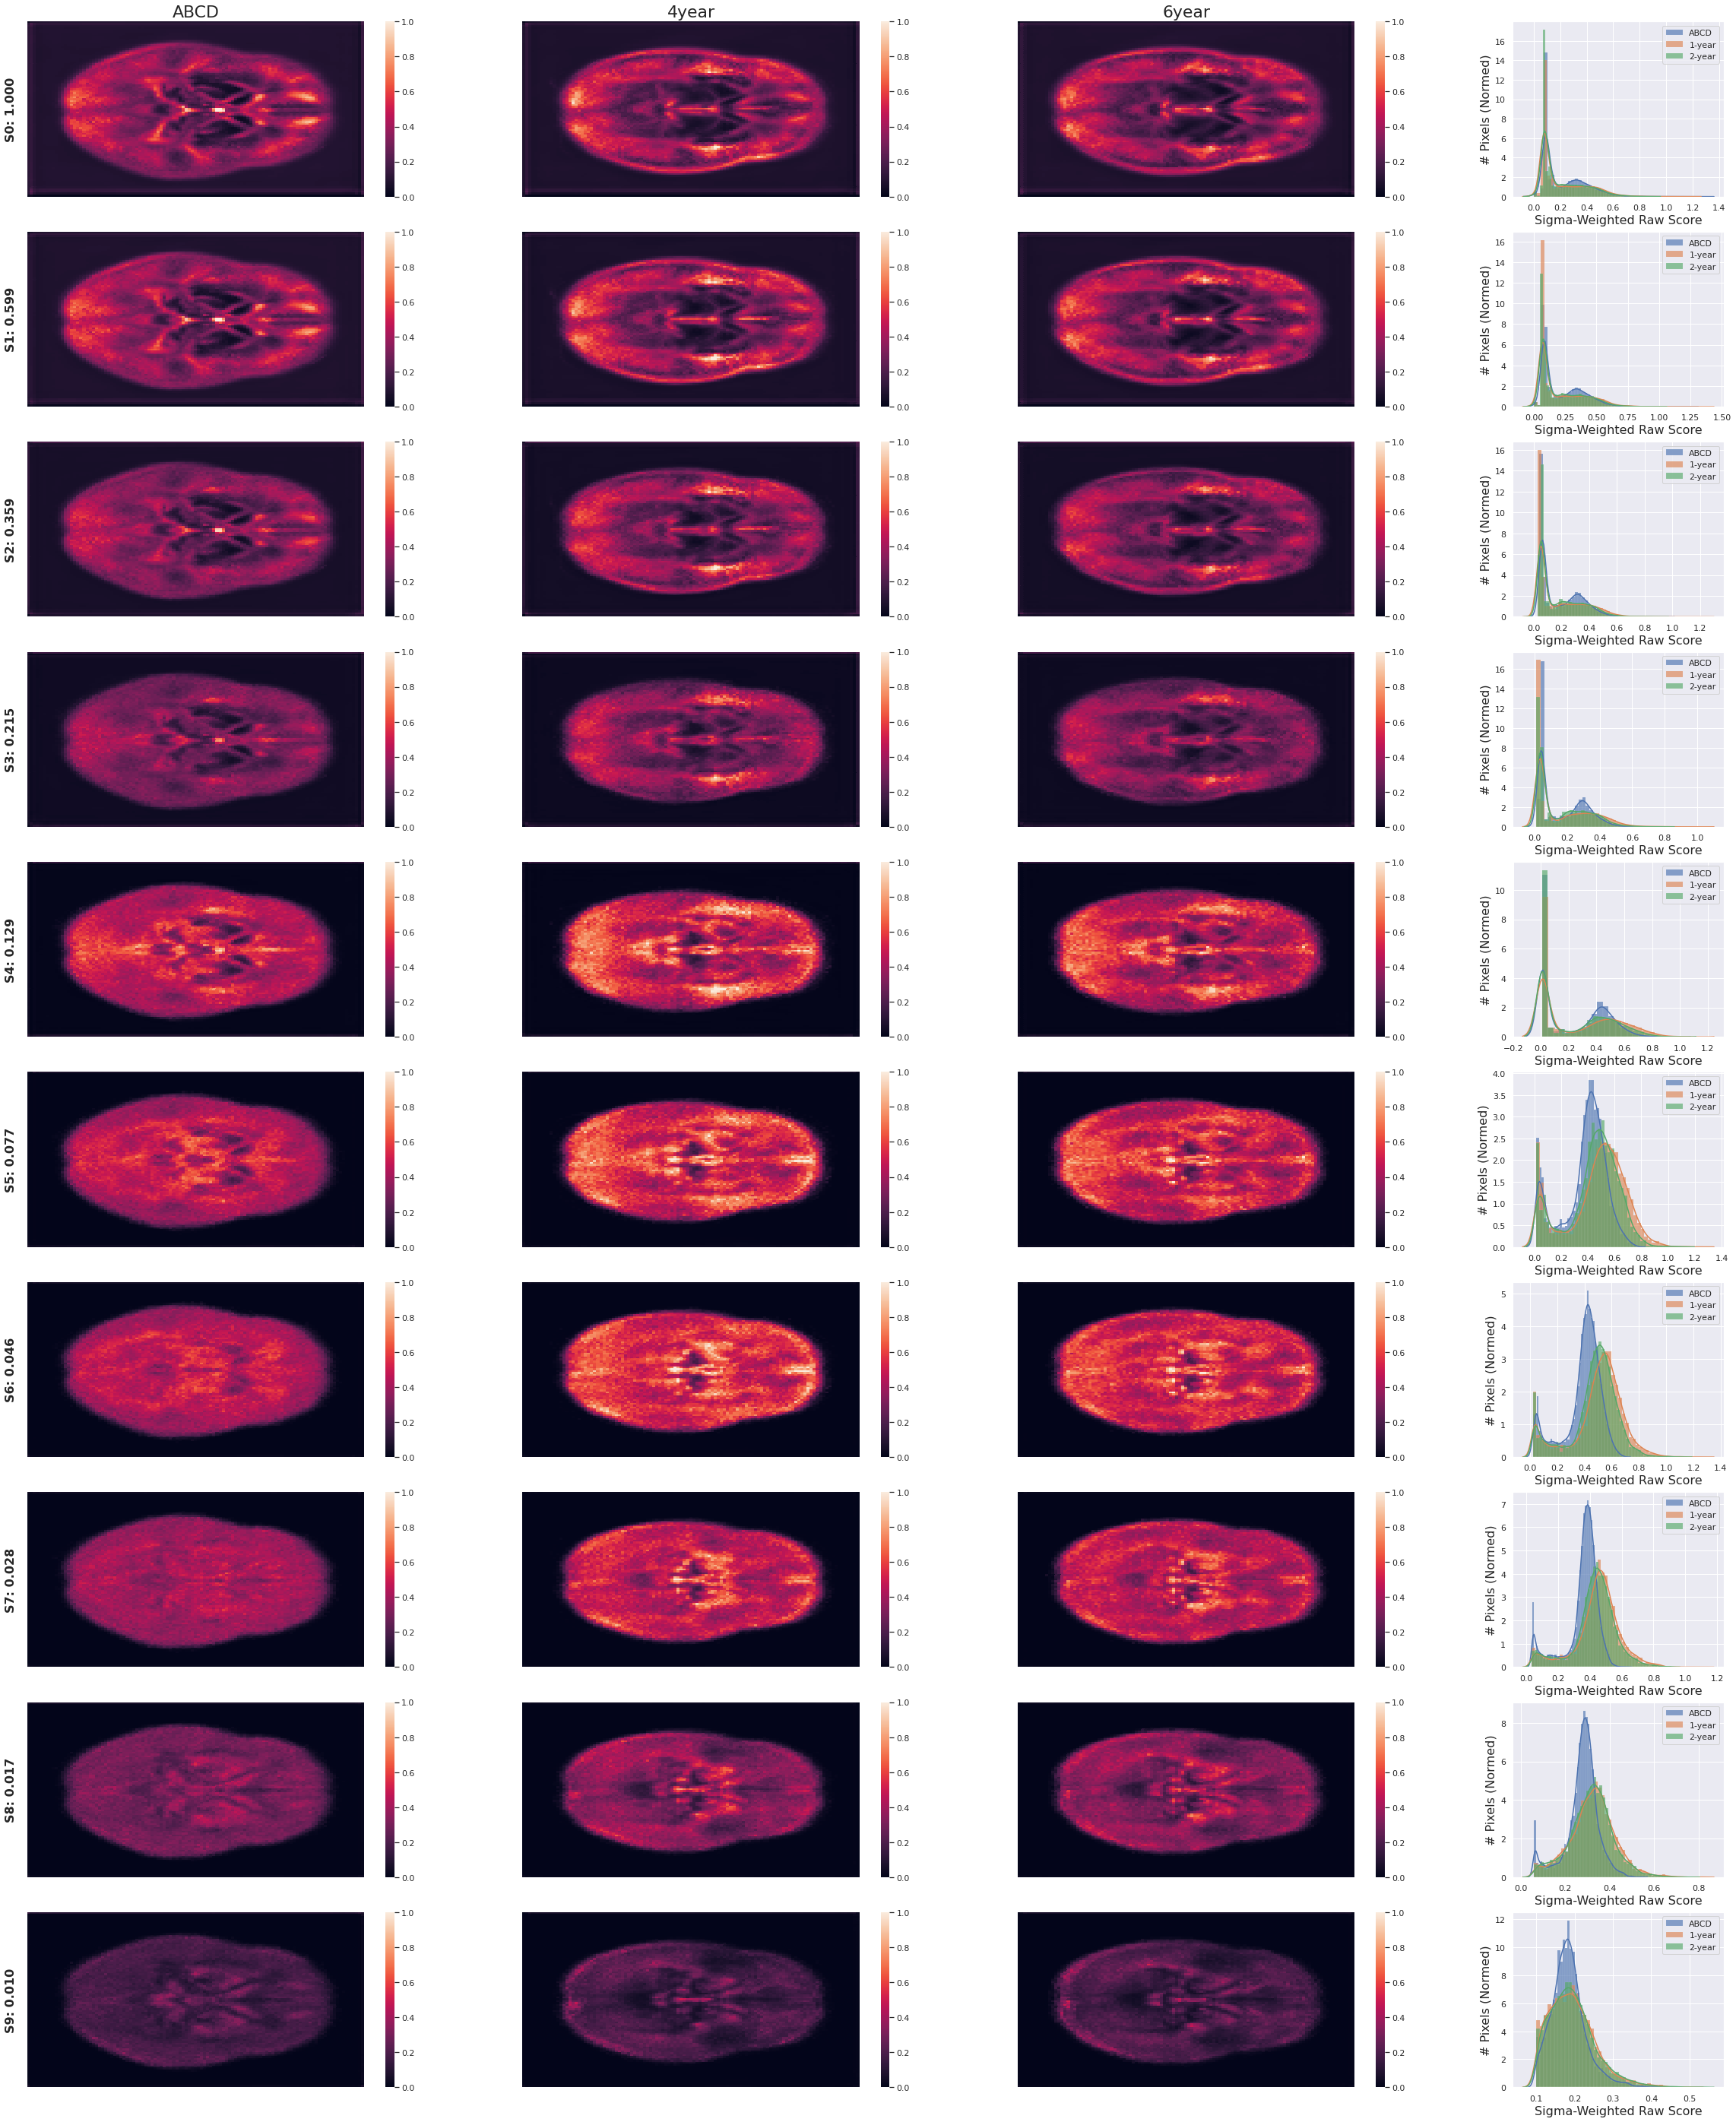

In [102]:
eps = 1e-3
fig, axs = plt.subplots(10, 4, figsize=(40, 50), gridspec_kw={'width_ratios': [2, 2, 2, 1]})
progress_bar = tqdm(SIGMAS, desc='Sigma: ?')

for idx, sigma in enumerate(progress_bar):
    progress_bar.set_description("Sigma: {:.4f}".format(sigma))
    
    for i, score_dict in enumerate([inlier_dist, outlier_dist, outlier_dist_2]):
        _logits = np.squeeze(score_dict[idx].numpy()) * sigma
        _logits = np.square(_logits)
        
        sigma_avg = np.mean(_logits, axis=0)
        sigma_avg = np.abs(sigma_avg)
        

#         _logits[_logits < eps] = 0
        
        sns.heatmap(sigma_avg, ax=axs[idx][i], vmin=0.0, vmax=1.0)
        
        # Get rid of x/y ticks
        axs[idx][i].xaxis.set_visible(False)
        axs[idx][i].yaxis.set_ticklabels([])
        
        _ax = sns.distplot(sigma_avg[sigma_avg>(eps/sigma)], hist_kws={"alpha":0.65, "linewidth": 0.1}, ax=axs[idx][-1])
        
    axs[idx][0].set_ylabel("S{:d}: {:.3f}".format(idx, sigma), fontweight="bold", fontsize=16)
    _ax.set(xlabel="Sigma-Weighted Raw Score", ylabel="# Pixels (Normed)")    
    _ax.legend(_labels)

for i,lab in enumerate(labels):
    axs[0][i].set_title(lab, fontsize=22)

plt.show()

### Viz Individual Samples

In [93]:
plt.close()

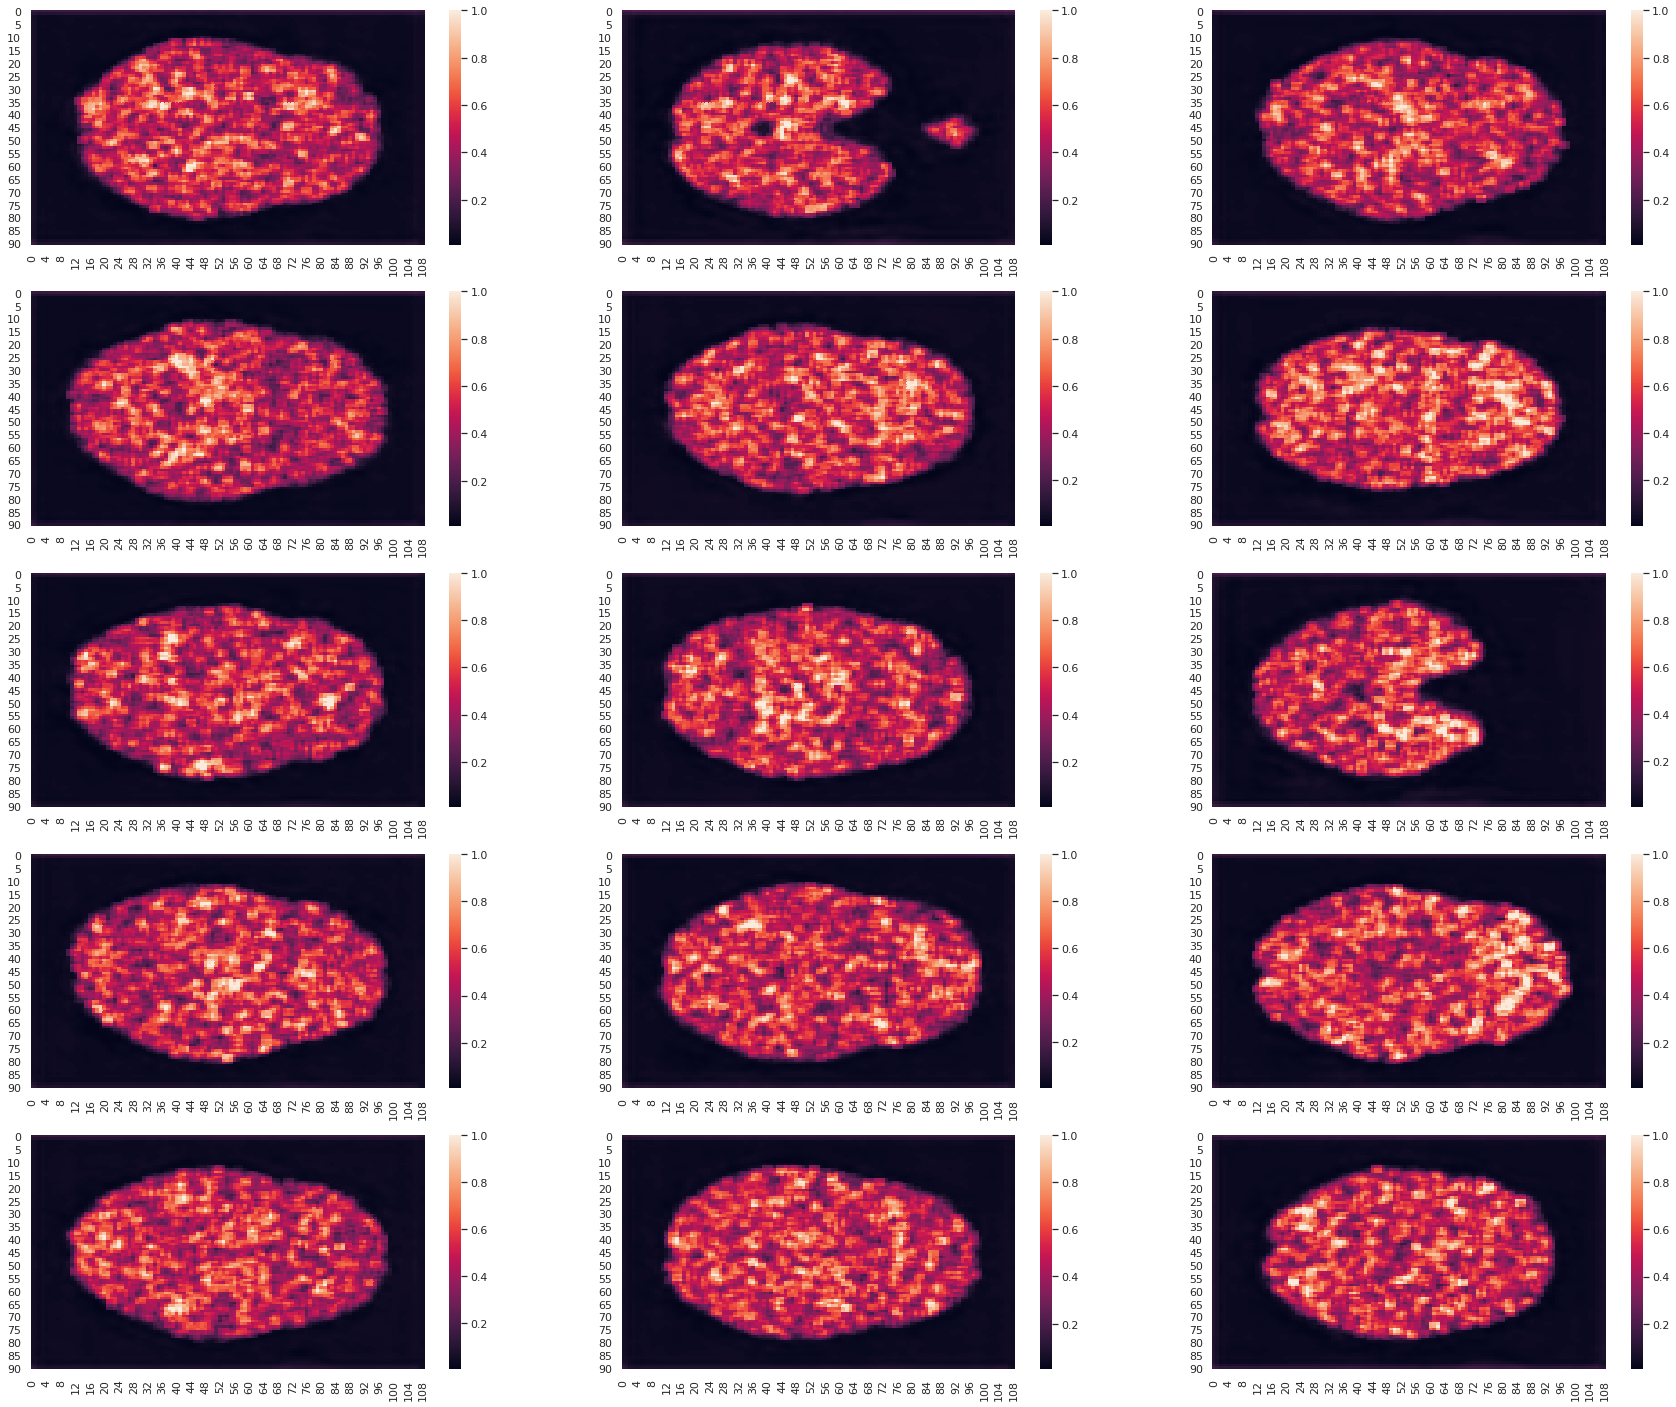

In [97]:
num_samples=15
inlier_scores = np.abs(np.squeeze(inlier_dist[6].numpy()[0:num_samples]) * SIGMAS[6])
fig, axs = plt.subplots(num_samples//3, 3, figsize=(30, num_samples//3 *5))
axs = axs.flatten()

for idx, x_score in enumerate(inlier_scores):
    sns.heatmap(uniform_filter(x_score, size=3), ax=axs[idx], vmax=1.0)
#     sns.heatmap(x_score, ax=axs[idx][0])

plt.show()

In [162]:
# inlier_dict[6] * sigmas[6]

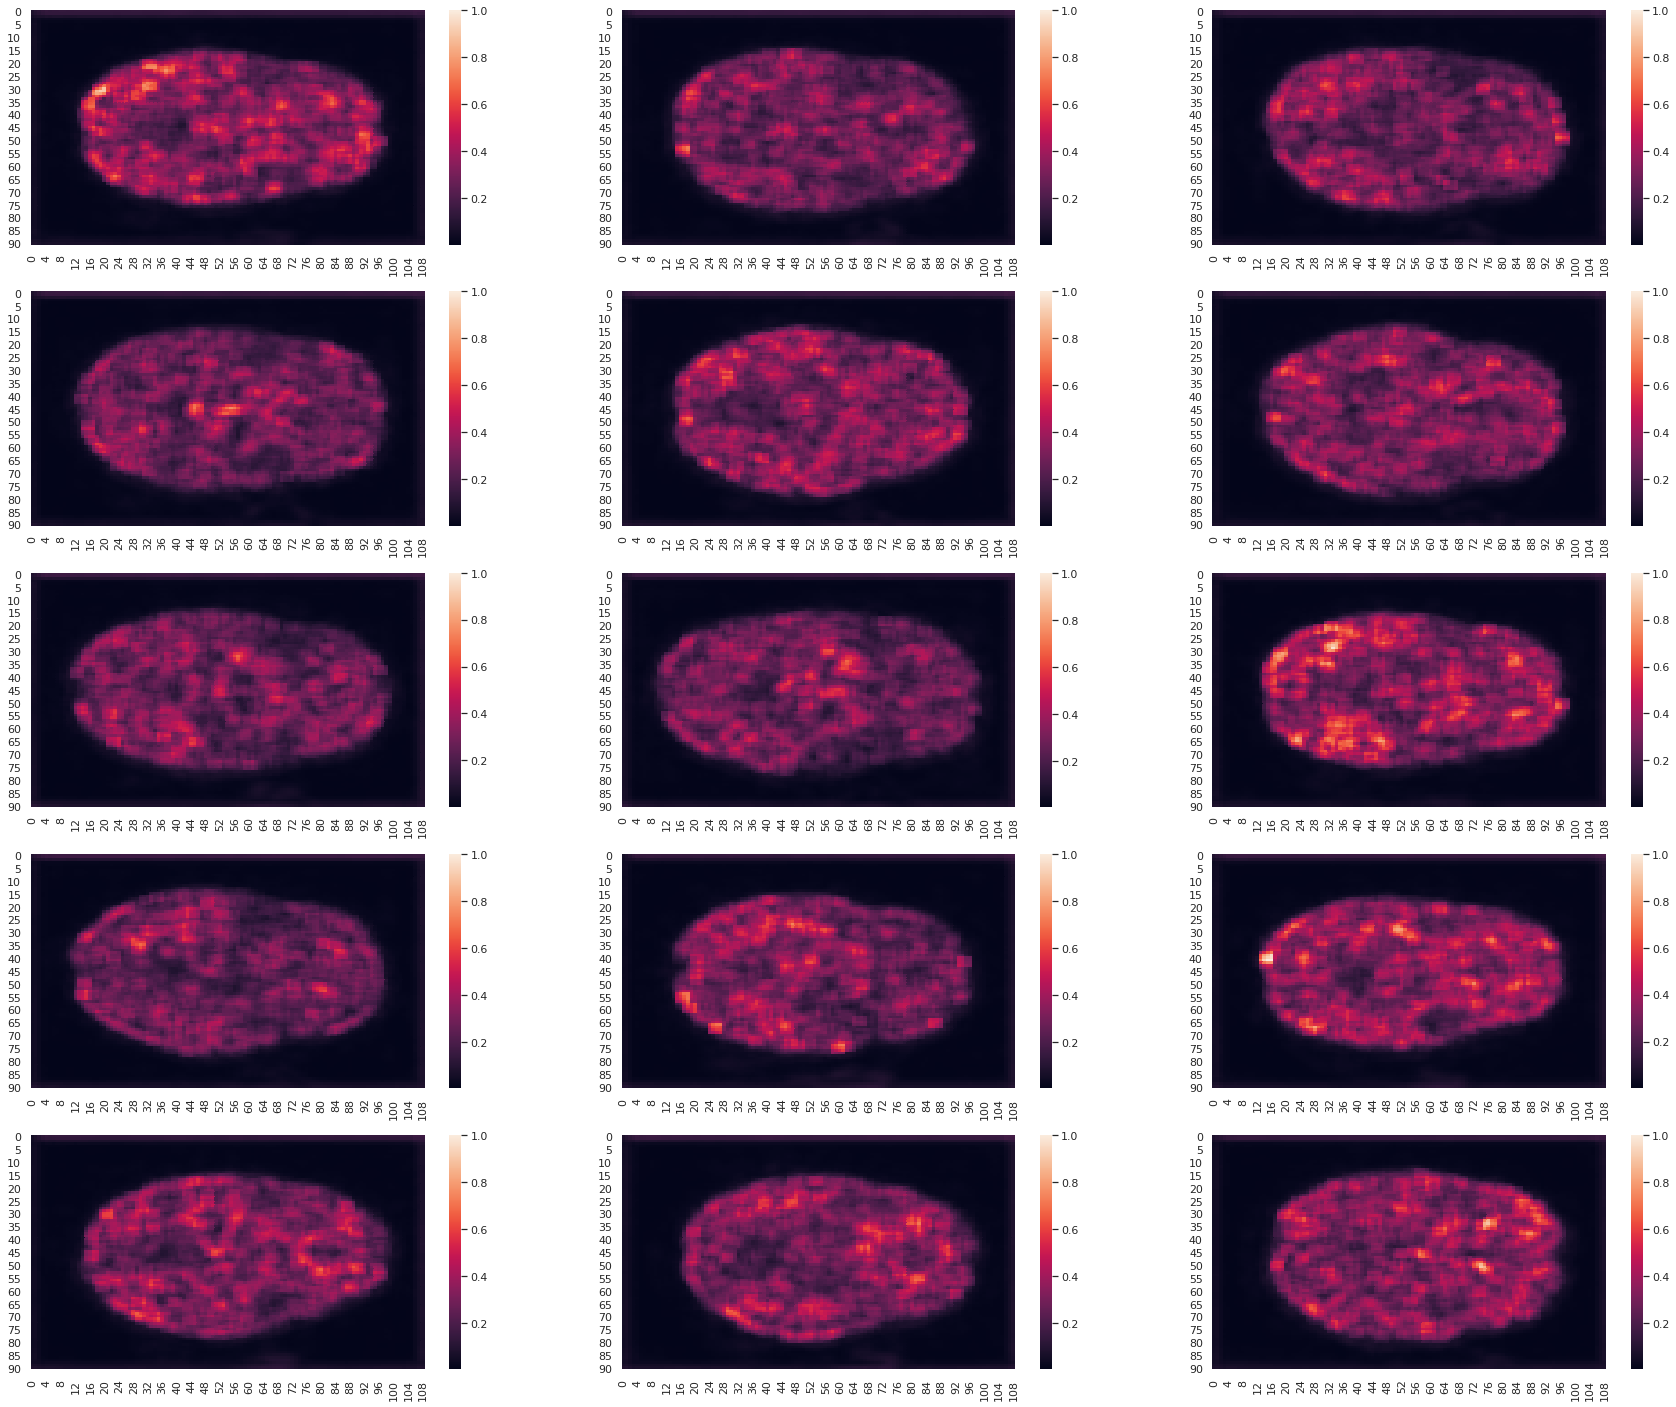

In [100]:
outlier_scores = np.abs(np.squeeze(outlier_dist[9].numpy()[0:num_samples]) * SIGMAS[9])
fig, axs = plt.subplots(num_samples//3, 3, figsize=(30, num_samples//3*5))
axs = axs.flatten()

for idx, x_score in enumerate(outlier_scores):
    sns.heatmap(uniform_filter(x_score, size=4), ax=axs[idx], vmax=1.0)
#     sns.heatmap(x_score, ax=axs[idx][0])

plt.show()

In [64]:
# L2-norm same as Frobenius

inlier_agg = tf.add_n([inlier_dict[x] * sigmas[x] for x in range(5,7)])
outlier_agg = tf.add_n([outlier_dict[x] * sigmas[x] for x in range(5,7)])

inlier_score = tf.norm(inlier_agg, axis=[1,2], ord="euclidean").numpy()
outlier_score = tf.norm(outlier_agg, axis=[1,2], ord="euclidean").numpy()

df = pd.DataFrame(np.concatenate((inlier_score, 
                            outlier_score), axis=-1),
             columns=["Inlier", "Outlier"])
df.describe()

Inlier     Outlier
count  580.000000  580.000000
mean    89.188988   99.211113
std      2.738710    3.981897
min     79.083313   87.559082
25%     87.463686   96.407366
50%     89.155556   99.231735
75%     90.891851  101.874155
max     97.743439  109.166290

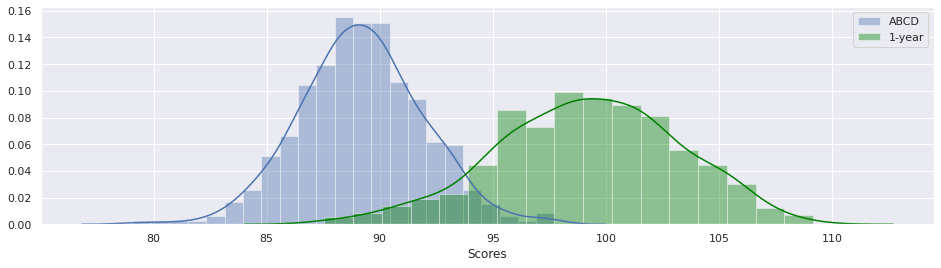

In [65]:
fig, ax = plt.subplots(1,1, figsize=(16,4))
sns.distplot(inlier_score, label="ABCD", ax=ax)
sns.distplot(outlier_score, color="green", label="1-year", ax=ax, axlabel="Scores")
plt.legend()
plt.show()

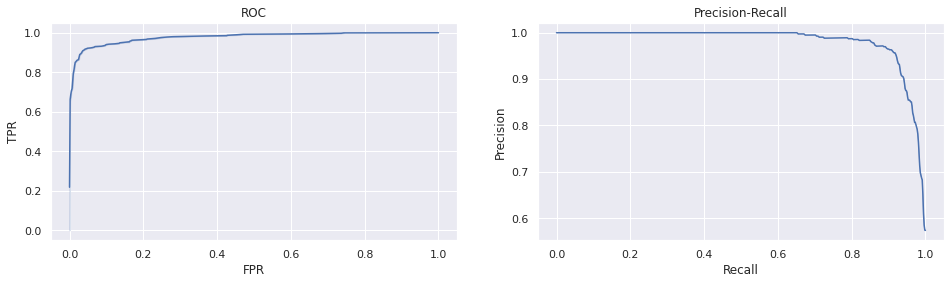

Inlier vs Outlier
----------------
ROC-AUC: 0.9776
PR-AUC: 0.9814
Avg Prec: 0.9814


In [66]:
metrics(inlier_score, outlier_score, plot=True, verbose=True)
plt.show()

#### ABCD vs 1-year

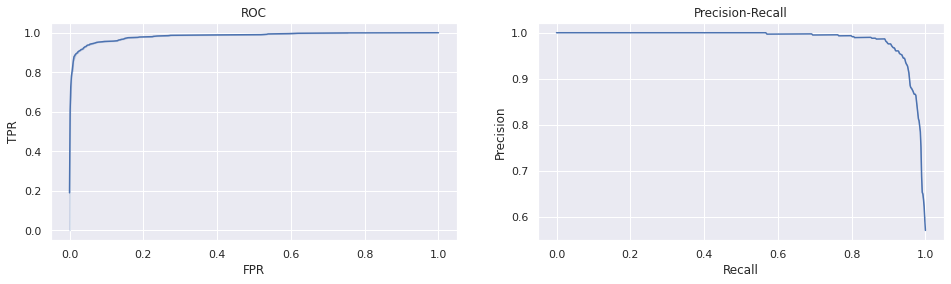

Inlier vs Outlier
----------------
ROC-AUC: 0.9835
PR-AUC: 0.9862
Avg Prec: 0.9862


(0.9834601664684899, 0.9862265946451173, 0.9862160605426233)

In [59]:
metrics(inlier_score, outlier_score, plot=True, verbose=True)

#### ABCD vs 2-year

In [60]:
# metrics(inlier_score, outlier_score, plot=True, verbose=True)

> ### Aggregating a samples scores *across* sigmas  

In [292]:
sigmas

array([1.        , 0.5994842 , 0.35938135, 0.21544345, 0.12915495,
       0.07742635, 0.04641588, 0.02782559, 0.016681  , 0.01      ],
      dtype=float32)

In [303]:
inlier_dict_tf = tf.squeeze(tf.stack([inlier_dict[x] for x in inlier_dict])) * sigmas.reshape(-1,1,1,1)
outlier_dict_tf = tf.squeeze(tf.stack([outlier_dict[x] for x in outlier_dict])) * sigmas.reshape(-1,1,1,1)

In [304]:
inlier_sample_avg = tf.reduce_sum(inlier_dict_tf, axis=0)
outlier_sample_avg = tf.reduce_sum(outlier_dict_tf, axis=0)

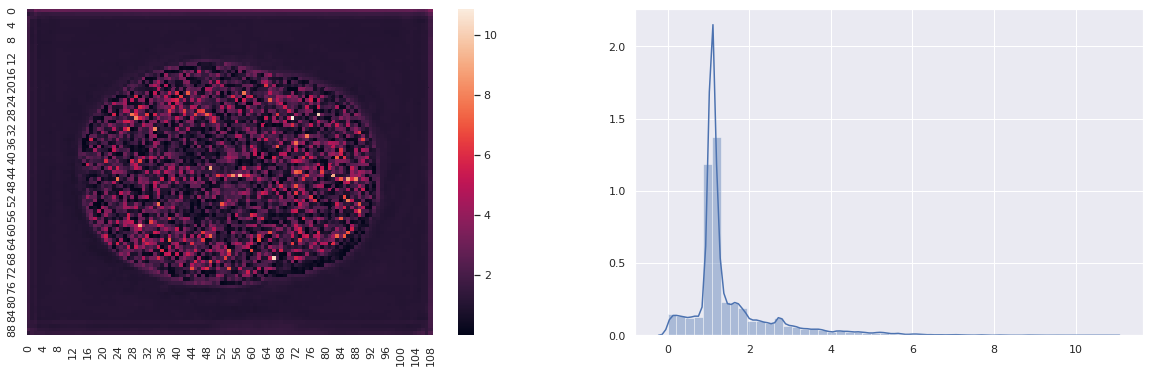

In [307]:
x_score = np.abs(outlier_sample_avg[0,...].numpy())
# inlier_scores = np.abs(np.squeeze(inlier_logits_.numpy()[0:num_samples,...,0]))
fig, axs = plt.subplots(1, 2, figsize=(20,6))

sns.heatmap(x_score, ax=axs[0])
sns.distplot(x_score, ax=axs[1])
plt.show()

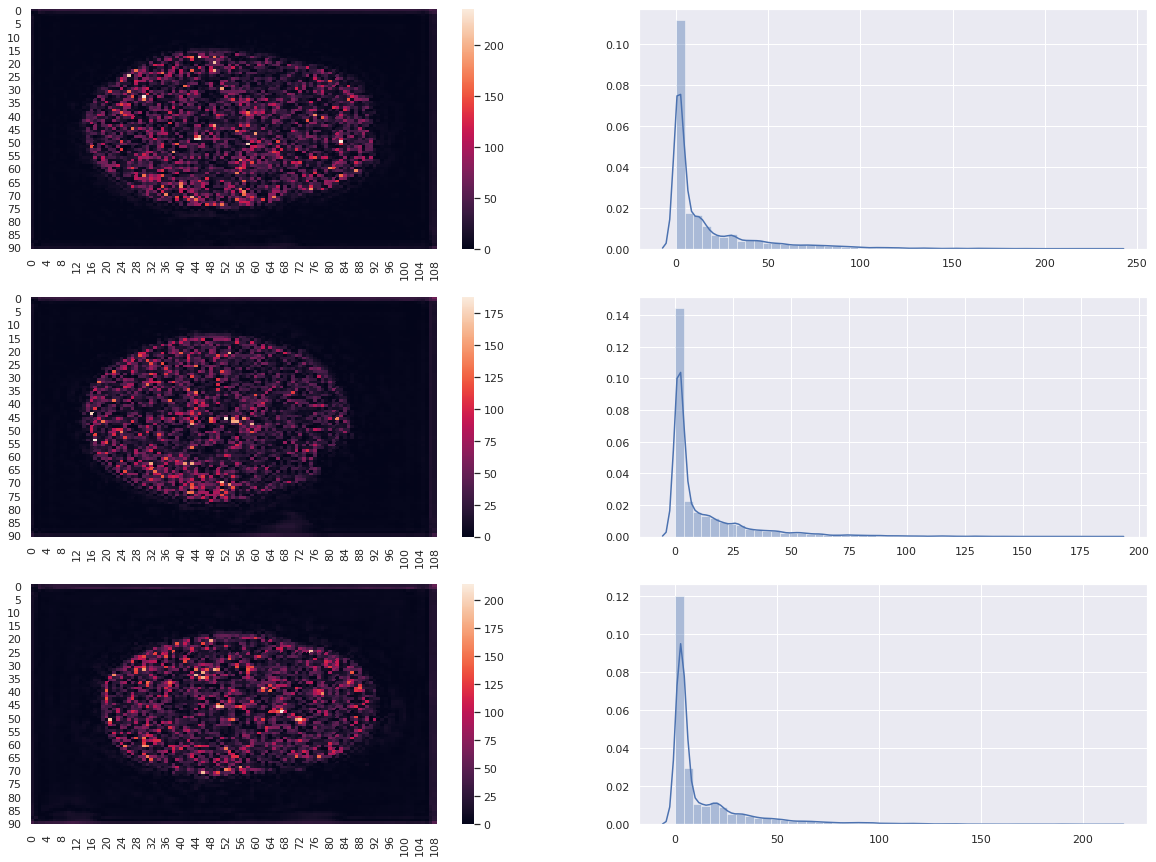

In [117]:
outlier_logits_ = outlier_dict[idx]
outlier_scores = np.abs(np.squeeze(outlier_logits.numpy()[0:num_samples,...,0]))
fig, axs = plt.subplots(num_samples, 2, figsize=(20, num_samples*5))
for idx, x_score in enumerate(outlier_scores):
#     sns.heatmap(uniform_filter(x_score, size=2), ax=axs[idx][0])
    sns.heatmap(x_score, ax=axs[idx][0], vmin=0)
    sns.distplot(x_score[x_score > 1e-1], ax=axs[idx][1])
plt.show()